# Data Science in Economics and Business - Class Project
In this class project, you are supposed to work with experimental data from the paper "The Many Faces of Human Sociality: Uncovering the Distribution and Stability of Social Preferences" by Bruhin, Fehr, and Schunk, published in the *Journal of the European Economic Association* 17(4): 1025-1069, 2019: https://doi.org/10.1093/jeea/jvy018

**IMPORTANT:** <br>
Please enter the matriculation number of all group members here:
1. 2493143
2. 2260326
3. 2796816

In this class project, you will use the different techniques taught in the course: data handling, data visualization, and machine learning.

First load the necessary packages. <br>
If you want to use additional libraries you can add them to the following cell:

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

The authors observe human behavior in the so-called dictator game: One player (*dictator*) receives a certain amount of money and can distribute this endowment between herself and another player (*receiver*). The decision of the dictator is implemented, and the receiver has no choice to take and must accept the dictator's decision. <br>
The authors employ a binary version of the dictator game in which the dictator can choose between two alternative allocation options *X* and *Y*. Each dictator in the experiment plays 30 of these dictator games with varying pairs of decision alternatives. <br>
All subjects in the experiment were students from the University of Zurich and the Swiss Federal Institute of Technology Zurich.

# Problem 4 - Unsupervised Machine Learning 
Use subjects' behaviors and information from the questionnaire to cluster individuals. <br>
Which is the optimal number of clusters? <br>
Can you provide an intuition for the clusters you identified? <br>
Do the clusters change when you include the imputed preferences from Problem 3c)?


**Aggregating and merging the datasets:** <br>
In the first step, the data on the selection behavior of dictators is aggregated in such a way that for each subject, information is available on how altruistic a dictator was in their selection. The context is always displayed, allowing one to see whether the decisions favored the dictator or the fellow player. Furthermore, subjects without sufficient data are removed from the DataFrame. <br>

In [74]:
# Load the two datasets
choices = pd.read_csv('data/choices.csv')
subjects = pd.read_csv('data/subjects.csv')

# Aggregating the selection behavior of dictators
def aggregate_choices(choices):
    choices['chosen_x_advantageous'] = choices.apply(lambda row: row['choice_x'] == 1 and row['r_x'] == 1, axis=1)
    choices['chosen_x_disadvantageous'] = choices.apply(lambda row: row['choice_x'] == 1 and row['s_x'] == 1, axis=1)
    
    choices['chosen_y_advantageous'] = choices.apply(lambda row: row['choice_x'] == 0 and row['r_y'] == 1, axis=1)
    choices['chosen_y_disadvantageous'] = choices.apply(lambda row: row['choice_x'] == 0 and row['s_y'] == 1, axis=1)

    agg_data = choices.groupby('sid').agg({
        'choice_x': 'mean',  # Average selection of payout option X
        'chosen_x_advantageous': lambda x: x.sum() / len(x),  # Proportion of times a subject chose Option X when it was advantageous for the dictator
        'chosen_x_disadvantageous': lambda x: x.sum() / len(x),  # Proportion of times a subject chose Option X when it was disadvantageous for the dictator
        'chosen_y_advantageous': lambda x: x.sum() / len(x),  # Proportion of times a subject chose Option Y when it was advantageous for the dictator
        'chosen_y_disadvantageous': lambda x: x.sum() / len(x)  # Proportion of times a subject chose Option Y when it was disadvantageous for the dictator
    }).reset_index()
    
    return agg_data

agg_choices = aggregate_choices(choices)

# Merging the aggregated data on selection behavior with the subject data
merged_data = subjects.merge(agg_choices, on='sid')
data = merged_data.dropna()


**Feature selection and normalization of the data:** <br>
First, the fields that are not binary are identified from the features to be examined. These non-binary data are then normalized and scaled to make them more comparable. Additionally, the monthly income is log-transformed to improve the data distribution. After that, the binary and non-binary data are merged again.<br>

In [76]:

# Log-transform monthly income
data['log_pe_monthinc'] = np.log(data['pe_monthinc'] + 1)

# Features for clustering
features = [
    'bf_consciousness', 'bf_openness', 'bf_extraversion', 'bf_agreeableness', 
    'bf_neuroticism', 'cogabil', 'log_pe_monthinc', 'pe_age', 'pe_female',
    'choice_x', 'chosen_x_advantageous', 'chosen_x_disadvantageous',
    'chosen_y_advantageous', 'chosen_y_disadvantageous',
    'pe_D1_stud_natsci', 'pe_D1_stud_law', 'pe_D1_stud_socsci', 'pe_D1_stud_med'
]

# Separate binary and non-binary features
binary_features = ['pe_female', 'pe_D1_stud_natsci', 'pe_D1_stud_law', 'pe_D1_stud_socsci', 'pe_D1_stud_med']
non_binary_features = [f for f in features if f not in binary_features]

# Normalize the non-binary features
scaler = StandardScaler()
scaled_non_binary = scaler.fit_transform(data[non_binary_features])

# Combine scaled non-binary features with binary features
scaled_data = np.column_stack((scaled_non_binary, data[binary_features]))

**Selection of the optimal number of clusters:** <br>
The optimal number of clusters can be determined using the Elbow Method and Silhouette Analysis.<br>

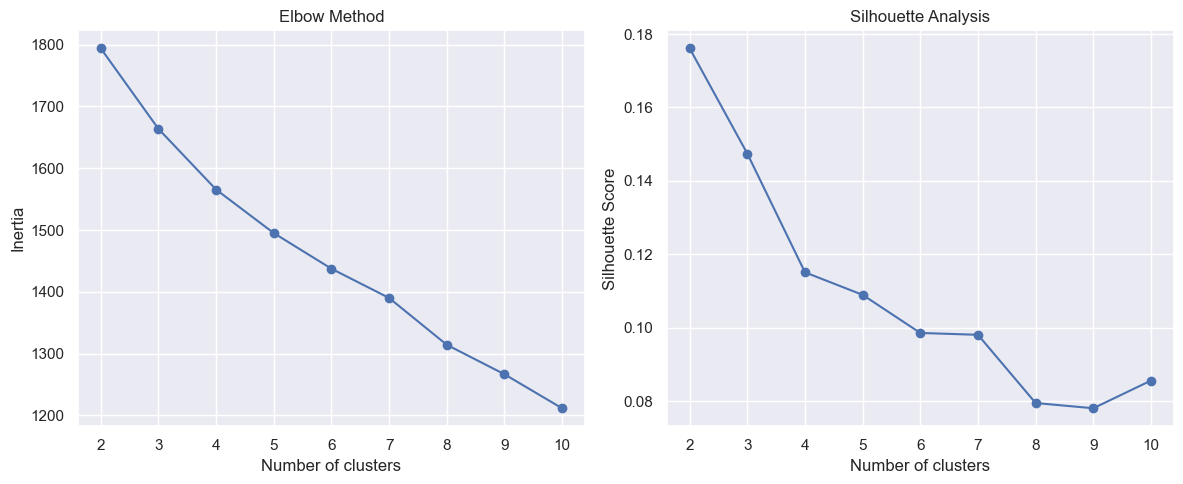

In [77]:
max_clusters = 10
inertias = []
silhouette_scores = []

for k in range(2, max_clusters+1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))

# Plot elbow curve and silhouette scores
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_clusters+1), inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(range(2, max_clusters+1), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')

plt.tight_layout()
plt.show()

**Final clustering and cluster distribution:** <br>
The optimal number of clusters can be set to 2 based on the two methods. The k-Means cluster analysis is then performed, and the distribution of the clusters is visualized using Principal Component Analysis (PCA).<br>

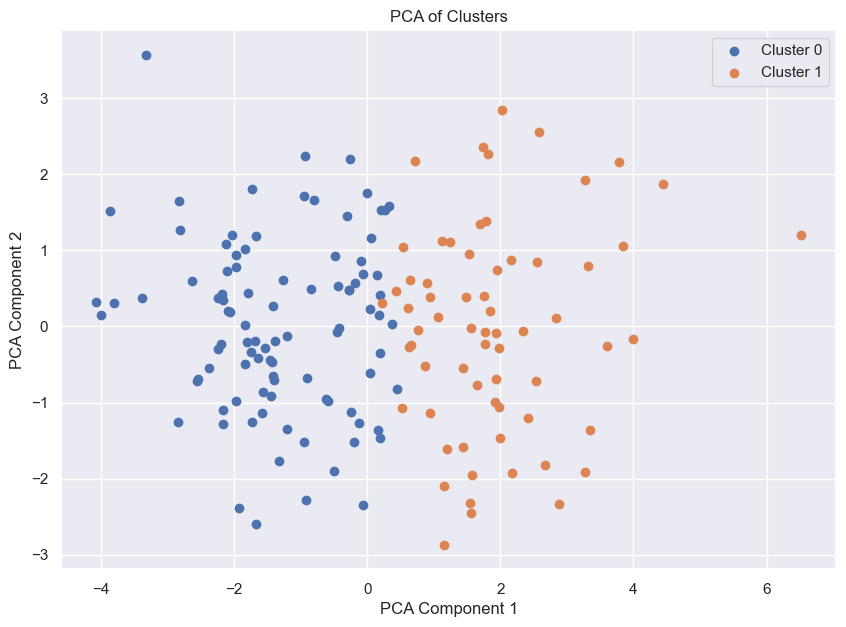

In [78]:

# Optimal number of clusters based on the two methods
optimal_k = 2

# Perform final clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_data)
data['Cluster'] = clusters

# PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)
plt.figure(figsize=(10, 7))
for i in range(optimal_k):
    cluster_points = pca_components[data['Cluster'] == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Clusters')
plt.legend()
plt.show()

**Result of the cluster analysis and interpretation of the selection behavior:** <br>
For each cluster, the average values of the selected features are displayed. The following assumptions are made regarding the selection behavior:

- A high avg. `choice_x` value indicates that the dictator frequently chose Option X, which tends to indicate a maximization of their own gain.
- A high avg. `chosen_x_advantageous` value indicates that the dictator often chose Option X, where they had an advantage over the fellow player and maximized their own payout.
- A high avg. `chosen_x_disadvantageous` value indicates that the dictator often chose Option X, where their own payout was maximized, but the fellow player received a higher payout than the dictator.
- A high avg. `chosen_y_advantageous` value indicates that the dictator often chose Option Y, where they had an advantage over the fellow player.
- A high avg. `chosen_y_disadvantageous` value indicates that the dictator often chose Option Y, where the fellow player had an advantage over the dictator.

In [79]:
# Result of k-Means Clustering
for i in range(optimal_k):
    print(f"\nCluster {i} characteristics:")
    cluster_data = data[data['Cluster'] == i]
    for feature in features:
        mean_value = cluster_data[feature].mean()
        print(f"{feature}: {mean_value:.2f}")



Cluster 0 characteristics:
bf_consciousness: 7.57
bf_openness: 21.11
bf_extraversion: 5.96
bf_agreeableness: 8.42
bf_neuroticism: 3.34
cogabil: 7.68
log_pe_monthinc: 6.06
pe_age: 21.33
pe_female: 0.56
choice_x: 0.89
chosen_x_advantageous: 0.42
chosen_x_disadvantageous: 0.48
chosen_y_advantageous: 0.05
chosen_y_disadvantageous: 0.06
pe_D1_stud_natsci: 0.61
pe_D1_stud_law: 0.07
pe_D1_stud_socsci: 0.09
pe_D1_stud_med: 0.18

Cluster 1 characteristics:
bf_consciousness: 6.18
bf_openness: 20.69
bf_extraversion: 6.08
bf_agreeableness: 7.91
bf_neuroticism: 4.57
cogabil: 6.11
log_pe_monthinc: 6.40
pe_age: 22.43
pe_female: 0.48
choice_x: 0.77
chosen_x_advantageous: 0.34
chosen_x_disadvantageous: 0.43
chosen_y_advantageous: 0.12
chosen_y_disadvantageous: 0.11
pe_D1_stud_natsci: 0.60
pe_D1_stud_law: 0.06
pe_D1_stud_socsci: 0.12
pe_D1_stud_med: 0.05


**Comparison of Selection Behavior:** <br>

- Cluster 0: Strong preference for selection option X regardless of the fellow player's payout amount. Indicates maximization of their own total payout.

- Cluster 1: Moderate preference for selection option X. Indicates maximization of their own total payout, but with more frequent selection of option Y (even at a disadvantage). Overall fairer.

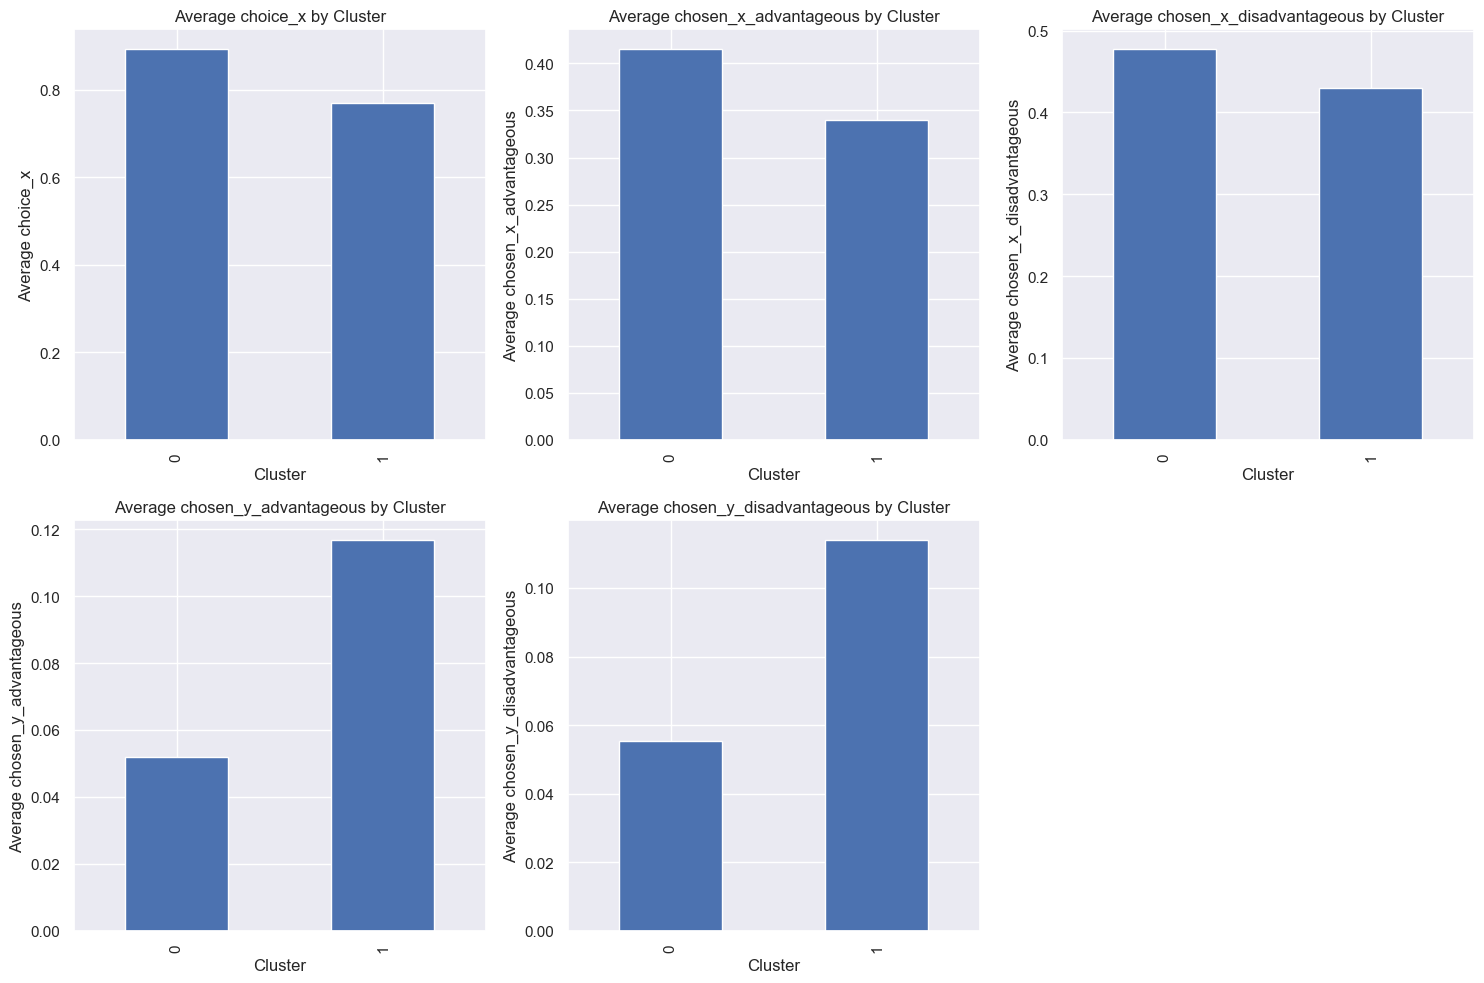

In [80]:

decision_features = ['choice_x', 'chosen_x_advantageous', 'chosen_x_disadvantageous', 'chosen_y_advantageous', 'chosen_y_disadvantageous']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(decision_features):
    plt.subplot(2, 3, i + 1)
    data.groupby('Cluster')[feature].mean().plot(kind='bar')
    plt.title(f'Average {feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(f'Average {feature}')
plt.tight_layout()
plt.show()

**Interpretation of Personality Traits, Cognitive Abilities, Income, and Demographic Characteristics:** <br>
- Cluster 0: The dictators tend to be conscientious, open, and less neurotic. They have high cognitive abilities and a moderate income. They are predominantly female and younger.

- Cluster 1: The dictators have lower conscientiousness scores and higher neuroticism scores. They show lower cognitive abilities but have a higher income. They are somewhat older, and the proportion of female subjects is lower.


Big Five traits analysis:

bf_consciousness:
  Cluster 0: 7.57
  Cluster 1: 6.18

bf_openness:
  Cluster 0: 21.11
  Cluster 1: 20.69

bf_extraversion:
  Cluster 0: 5.96
  Cluster 1: 6.08

bf_agreeableness:
  Cluster 0: 8.42
  Cluster 1: 7.91

bf_neuroticism:
  Cluster 0: 3.34
  Cluster 1: 4.57


<Figure size 1000x500 with 0 Axes>

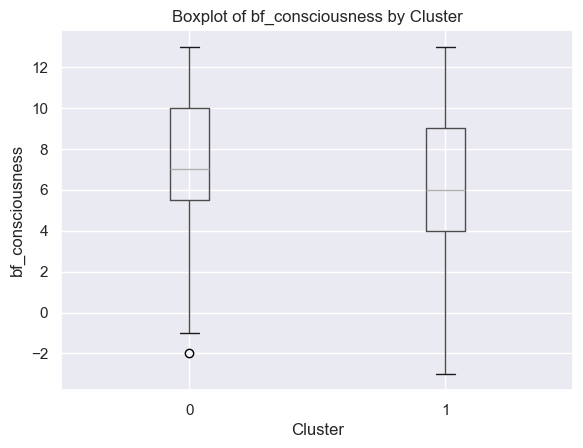

<Figure size 1000x500 with 0 Axes>

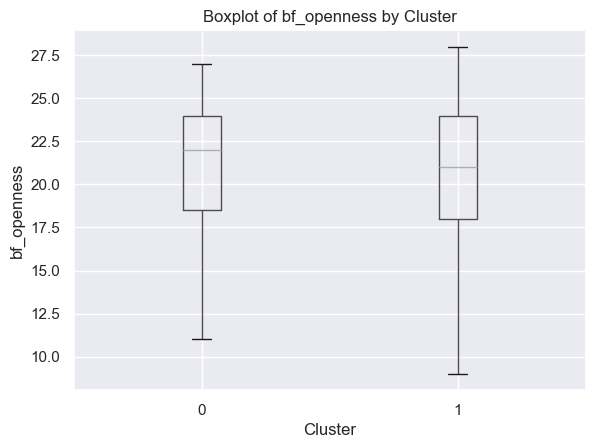

<Figure size 1000x500 with 0 Axes>

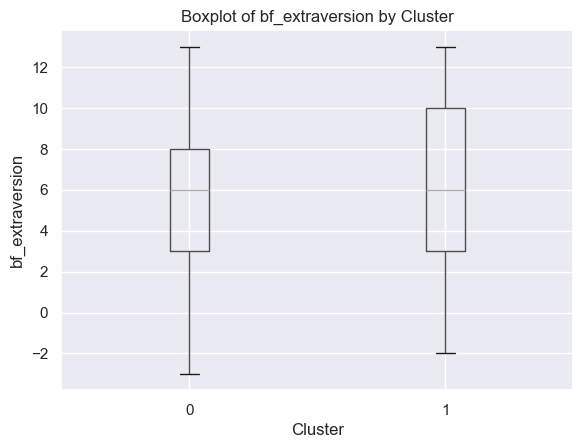

<Figure size 1000x500 with 0 Axes>

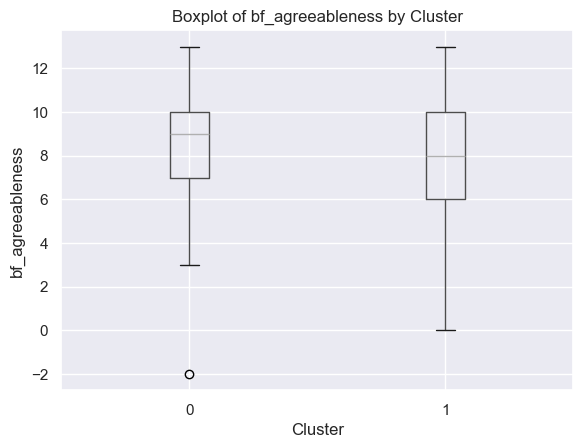

<Figure size 1000x500 with 0 Axes>

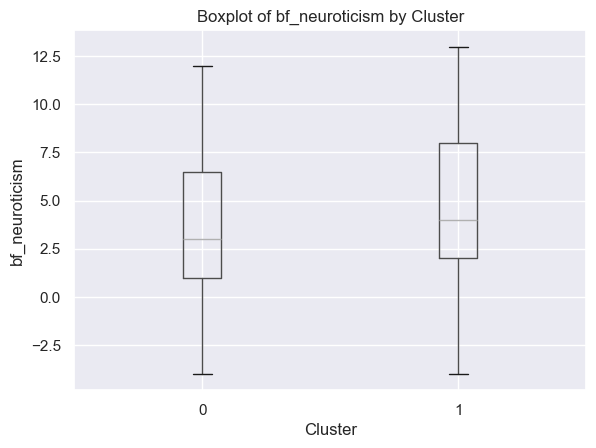

In [81]:
# Analysis of Big Five traits
print("\nBig Five traits analysis:")
for trait in ['bf_consciousness', 'bf_openness', 'bf_extraversion', 'bf_agreeableness', 'bf_neuroticism']:
    print(f"\n{trait}:")
    for i in range(optimal_k):
        cluster_mean = data[data['Cluster'] == i][trait].mean()
        print(f"  Cluster {i}: {cluster_mean:.2f}")


features = ['bf_consciousness', 'bf_openness', 'bf_extraversion', 'bf_agreeableness', 'bf_neuroticism']

for feature in features:
    plt.figure(figsize=(10, 5))
    data.boxplot(column=feature, by='Cluster')
    plt.title(f'Boxplot of {feature} by Cluster')
    plt.suptitle('')
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.show()

**Comparison of Study Fields:** <br>

- Cluster 0: The majority of dictators are studying natural sciences, followed by medicine. Social sciences and law are less represented.

- Cluster 1: Natural sciences also dominate here, followed by social sciences and law. Medicine is significantly less represented.


Study field distribution:

pe_D1_stud_natsci:
  Cluster 0: 0.61
  Cluster 1: 0.60

pe_D1_stud_law:
  Cluster 0: 0.07
  Cluster 1: 0.06

pe_D1_stud_socsci:
  Cluster 0: 0.09
  Cluster 1: 0.12

pe_D1_stud_med:
  Cluster 0: 0.18
  Cluster 1: 0.05


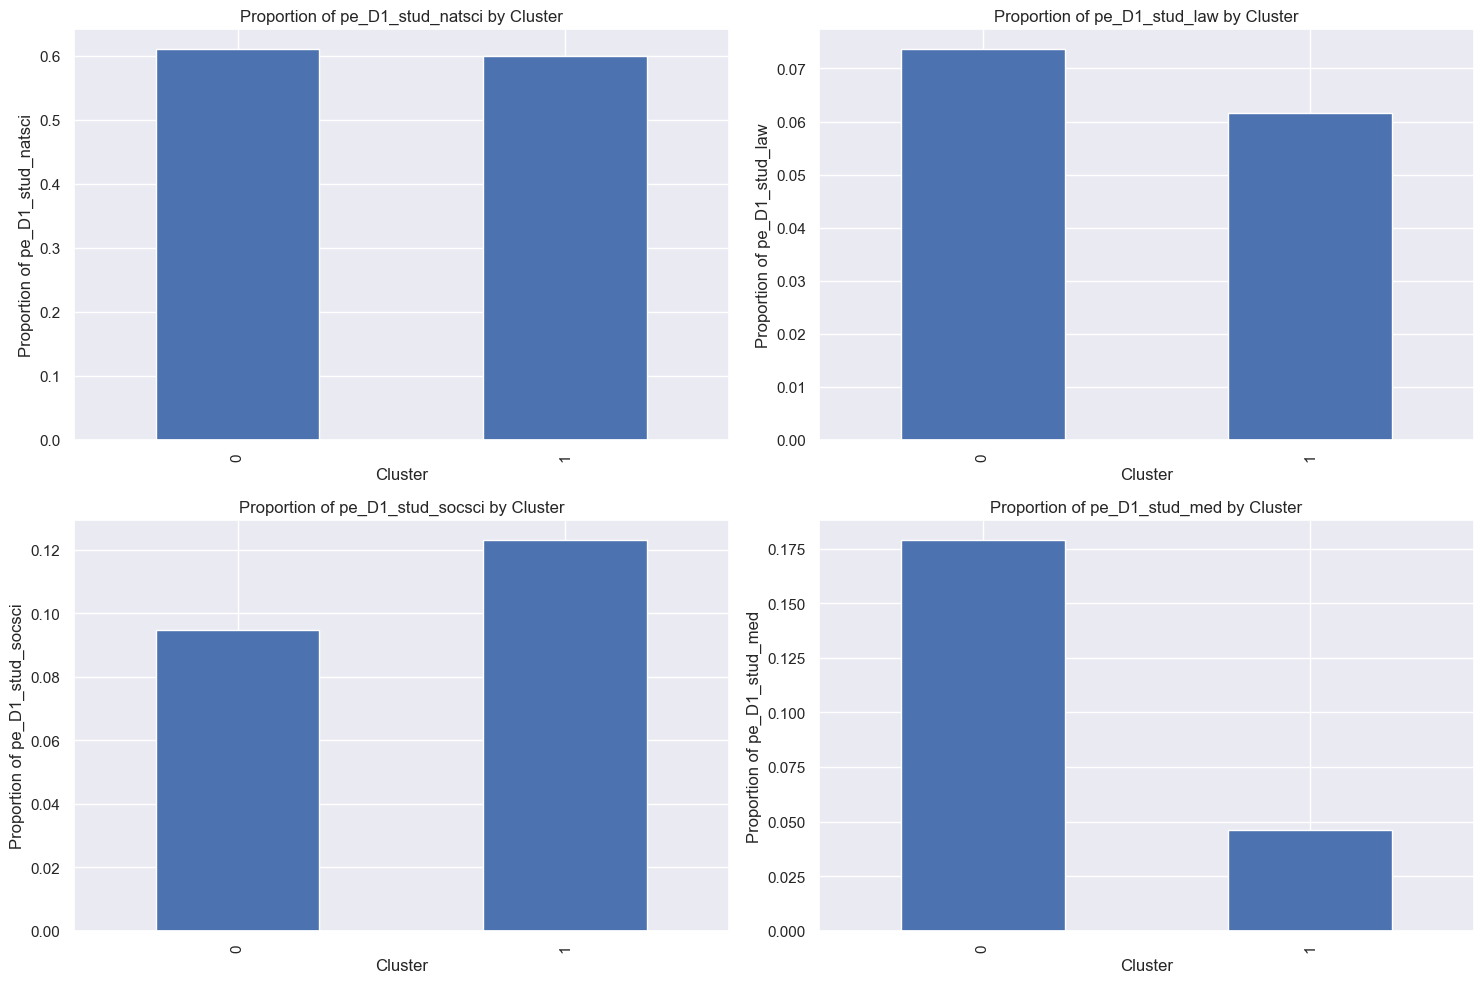

In [65]:
print("\nStudy field distribution:")
study_fields = ['pe_D1_stud_natsci', 'pe_D1_stud_law', 'pe_D1_stud_socsci', 'pe_D1_stud_med']
for field in study_fields:
    print(f"\n{field}:")
    for i in range(optimal_k):
        cluster_proportion = data[data['Cluster'] == i][field].mean()
        print(f"  Cluster {i}: {cluster_proportion:.2f}")

study_fields = ['pe_D1_stud_natsci', 'pe_D1_stud_law', 'pe_D1_stud_socsci', 'pe_D1_stud_med']

plt.figure(figsize=(15, 10))
for i, field in enumerate(study_fields):
    plt.subplot(2, 2, i + 1)
    data.groupby('Cluster')[field].mean().plot(kind='bar')
    plt.title(f'Proportion of {field} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(f'Proportion of {field}')
plt.tight_layout()
plt.show()

**Cluster Analysis with imputed preferences:** <br>
- The curves have changed slightly in the Elbow Method and Silhouette Analysis with the imputed data, but the number of clusters remain the same.
- The PCA looks slightly different, less distributed.

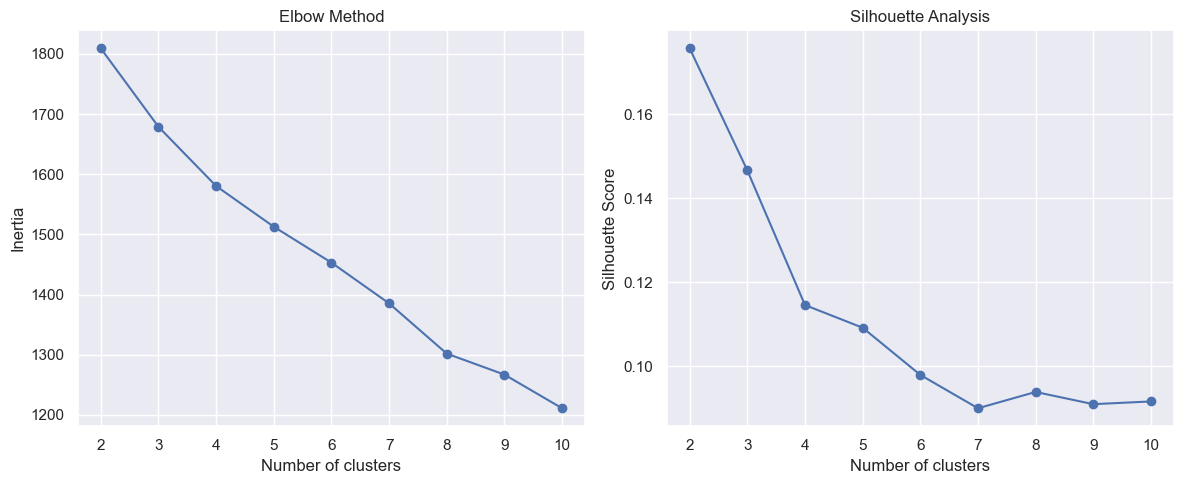

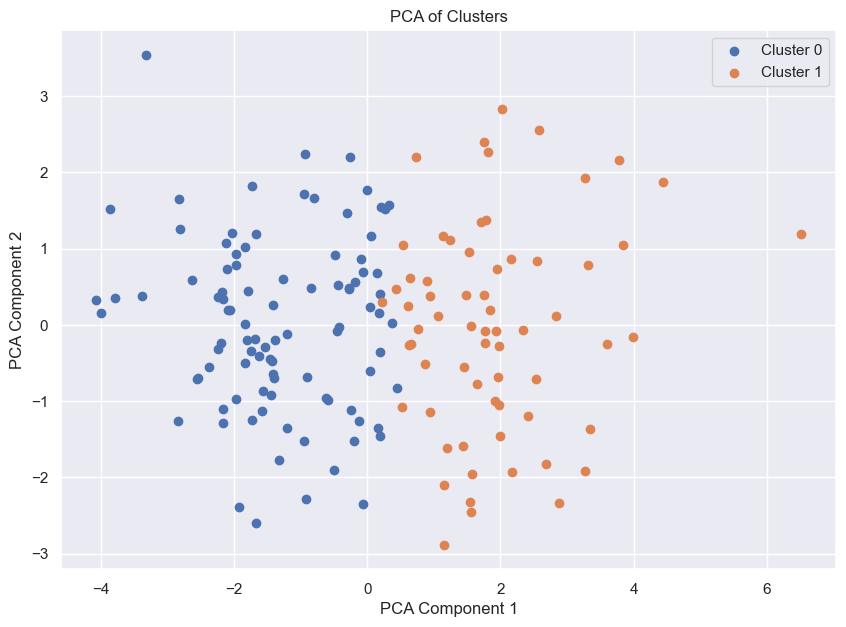

In [82]:
# Load the imputed dataset
subjects_with_predictions = pd.read_csv('data/subjects_with_predictions.csv')
subjects = pd.read_csv('data/subjects.csv')

subjects_imputed = subjects.copy()
predicted_country = subjects_with_predictions[['sid', 'predicted_country']]
subjects_copy = subjects_imputed.merge(predicted_country, on='sid', how='left')

merged_data_imputed = subjects_copy.merge(agg_choices, on='sid')
data_imputed = merged_data_imputed.dropna()


data_imputed['log_pe_monthinc'] = np.log(data_imputed['pe_monthinc'] + 1)

# One-hot encode 'predicted_country'
country_encoded = pd.get_dummies(data_imputed['predicted_country'], prefix='country')
data_imputed = pd.concat([data_imputed, country_encoded], axis=1)


# Features for clustering
features_imputed = [
    'bf_consciousness', 'bf_openness', 'bf_extraversion', 'bf_agreeableness', 'bf_neuroticism', 'cogabil', 'log_pe_monthinc', 'pe_age', 'pe_female',
    'choice_x', 'chosen_x_advantageous', 'chosen_x_disadvantageous',
    'chosen_y_advantageous', 'chosen_y_disadvantageous',
    'pe_D1_stud_natsci', 'pe_D1_stud_law', 'pe_D1_stud_socsci', 'pe_D1_stud_med'
] + list(country_encoded.columns)

normalized_features = ['pe_female', 'pe_D1_stud_natsci', 'pe_D1_stud_law', 'pe_D1_stud_socsci', 'pe_D1_stud_med'] + list(country_encoded.columns)
to_normalize_features = [f for f in features_imputed if f not in normalized_features]


scaler = StandardScaler()
scaled_to_normalize_features = scaler.fit_transform(data_imputed[to_normalize_features])

scaled_data_imputed = np.column_stack((scaled_to_normalize_features, data_imputed[normalized_features]))

max_clusters = 10
inertias = []
silhouette_scores = []

for k in range(2, max_clusters+1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data_imputed)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_data_imputed, kmeans.labels_))

# Plot elbow curve and silhouette scores
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_clusters+1), inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(range(2, max_clusters+1), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')

plt.tight_layout()
plt.show()

# Optimal number of clusters based on the two methods
optimal_k = 2

# Imputed Dataset Clustering
kmeans_imputed = KMeans(n_clusters=optimal_k, random_state=42)
clusters_imputed = kmeans_imputed.fit_predict(scaled_data_imputed)
data_imputed['Cluster'] = clusters_imputed


# PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data_imputed)
plt.figure(figsize=(10, 7))
for i in range(optimal_k):
    cluster_points = pca_components[data_imputed['Cluster'] == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Clusters')
plt.legend()
plt.show()



**Comparison of characteristics of Clusters 0 and 1 from the original Dataset and imputed Dataset:** <br>
- The datasets for the Big Five personality traits are identical.

In [85]:
def print_comparison(data1, data2, features, clusters1, clusters2):
    print("{:<30} {:<15} {:<15}".format("Feature", "Original", "Imputed"))
    print("-" * 60)
    
    for i in range(len(set(clusters1))):
        print(f"\nCluster {i}")
        cluster_data1 = data1[clusters1 == i]
        cluster_data2 = data2[clusters2 == i]
        
        common_features = [f for f in features if f in data1.columns and f in data2.columns]
        for f in common_features:
            mean1 = cluster_data1[f].mean()
            mean2 = cluster_data2[f].mean()
            print("{:<30} {:<15.2f} {:<15.2f}".format(f, mean1, mean2))
        
        if 'predicted_country' in data2.columns:
            top_country = cluster_data2['predicted_country'].mode().iloc[0]
            print("{:<30} {:<15} {:<15}".format('predicted_country', 'N/A', top_country))

print_comparison(data, data_imputed, features, clusters, clusters_imputed)

Feature                        Original        Imputed        
------------------------------------------------------------

Cluster 0
bf_consciousness               7.57            7.57           
bf_openness                    21.11           21.11          
bf_extraversion                5.96            5.96           
bf_agreeableness               8.42            8.42           
bf_neuroticism                 3.34            3.34           
predicted_country              N/A             USA            

Cluster 1
bf_consciousness               6.18            6.18           
bf_openness                    20.69           20.69          
bf_extraversion                6.08            6.08           
bf_agreeableness               7.91            7.91           
bf_neuroticism                 4.57            4.57           
predicted_country              N/A             USA            
